In [83]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
import math
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import matplotlib as mpl
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import magma
import pandas as pd

In [84]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2025-07-19 12:58:00--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip.12’

book-crossings.zip. 100%[===================>]  24.88M   105MB/s    in 0.2s    

2025-07-19 12:58:01 (105 MB/s) - ‘book-crossings.zip.12’ saved [26085508/26085508]

Archive:  book-crossings.zip
replace BX-Book-Ratings.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [101]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})


In [98]:
# 1- Find all the books ISBN with same title and author
foo = df_books.groupby(['title', 'author']).agg(copies=('isbn', list), count=('isbn', 'count'))

# 2- Update all the ratings to point to the 1st ISBN found for that book
isbn_list = foo.query('count > 3')['copies'].tolist();
for ids in isbn_list:
  anchor, to_replace_list = ids[0], ids[1:]
  df_ratings.loc[df_ratings['isbn'].isin(to_replace_list), 'isbn'] = anchor
# CLEAN UP THE DATA

duplicate_books = df_books.groupby(['title', 'author']).title.agg(['count']).reset_index().query('count > 1')
duplicates_books_count = duplicate_books['count'].sum() - len(duplicate_books)

duplicate_ratings = df_ratings.groupby(['isbn', 'user']).isbn.agg(['count']).reset_index().query('count > 1')
duplicates_ratings_count = duplicate_ratings['count'].sum() - len(duplicate_ratings)

## Modify the DF to drop duplicate or irrelevant rows
df_books = df_books.drop_duplicates(subset=['title', 'author'])
df_ratings = df_ratings.drop_duplicates(subset=['isbn', 'user'])

print("Found and removed {:,} duplicate copies of books and {:,} duplicate copies of ratings".format(duplicates_books_count, duplicates_ratings_count))

## Books
books_count_before = len(df_books)
books_with_ratings = df_books.merge(df_ratings, on='isbn')
grouped_by_isbn = books_with_ratings.groupby(['isbn', 'title']).rating.agg(['count', 'mean']).reset_index()
books_min_count = 100
acceptable_books = grouped_by_isbn.query('count >= {}'.format(books_min_count))['isbn'].tolist()
grouped_by_isbn = grouped_by_isbn[grouped_by_isbn['isbn'].isin(acceptable_books)]
df_books = df_books[df_books['isbn'].isin(acceptable_books)]
books_count_after = len(df_books)
b_percent_change = round((books_count_before-books_count_after)/books_count_before*100, 2)
print('Removed {:,} rows ({}%) of books with less than {} reviews'.format(books_count_before - books_count_after, b_percent_change, books_min_count))

## Users
users_count_before = len(df_ratings)
ratings_min_count = 200;
df_ratings = df_ratings[df_ratings['isbn'].isin(acceptable_books)]
acceptable_users = df_ratings.groupby(['user']).rating.agg(['count']).reset_index().query('count >= {}'.format(ratings_min_count))['user'].tolist()
df_ratings = df_ratings[df_ratings['user'].isin(acceptable_users)]
users_count_after = len(df_ratings)
u_percent_change = round((users_count_before-users_count_after)/users_count_before*100,2)
print('Removed {:,} rows ({}%) of user ratings with less than {} reviews per account or invalid books'.format(users_count_before - users_count_after, u_percent_change, ratings_min_count))


Found and removed 20,175 duplicate copies of books and 1,385 duplicate copies of ratings
Removed 250,496 rows (99.72%) of books with less than 100 reviews
Removed 1,142,576 rows (99.49%) of user ratings with less than 200 reviews per account or invalid books


--- BASIC STATS

There is over 1,149,780 reviews in the database written by 105,283 users
The most active user (ID: #4213) has written 13,602 reviews


--- WHERE DO MOST OF OUR REVIEWS COME FROM?



/tmp/ipython-input-104-3019351171.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reviews_distribution = most_active_list['count'].groupby(


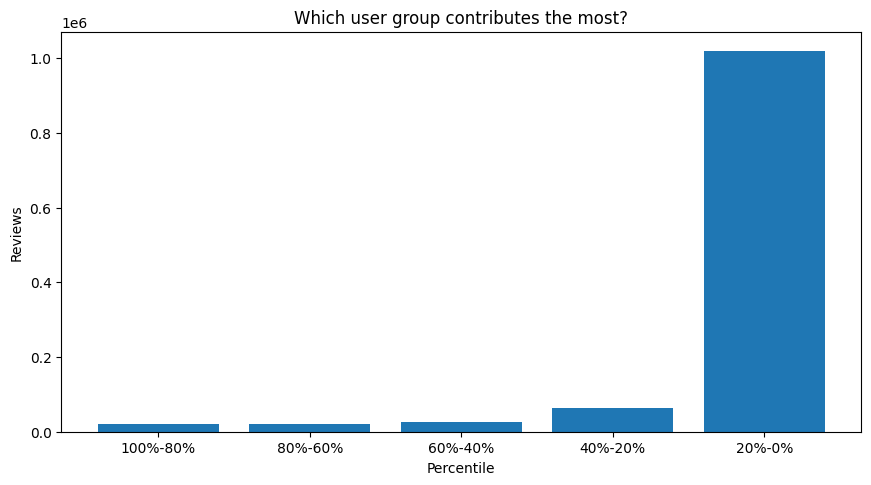


The top 20% of users contributed to 88.73% of reviews

Insight: Almost all our reviews come from 'superusers' who have a lot of opinions to share


--- HOW MANY REVIEWS DO USERS USUALLY LEAVE?



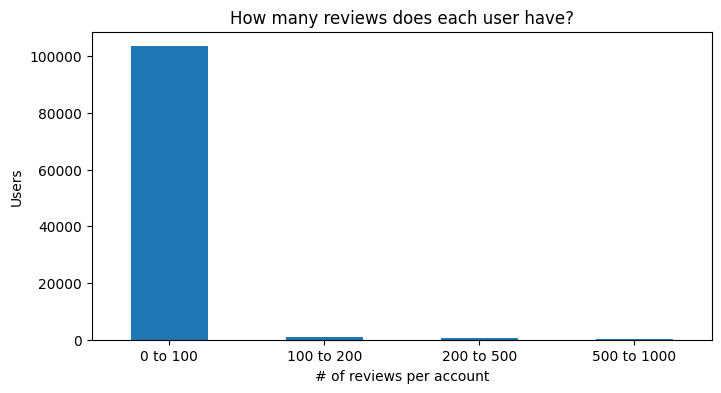


--- WHAT IS THE RELATIONSHIP B/T ENGAGEMENT RATE AND AVERAGE REVIEW SCORES?



/tmp/ipython-input-104-3019351171.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_distribution = most_active_list['mean'].groupby(


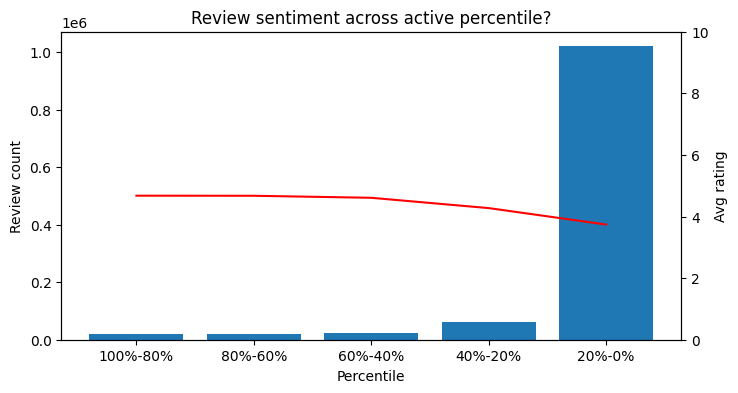


The average review is 2.87

--- WHAT REVIEW SCORES ARE MOST OFTEN POSTED ON THE SITE?



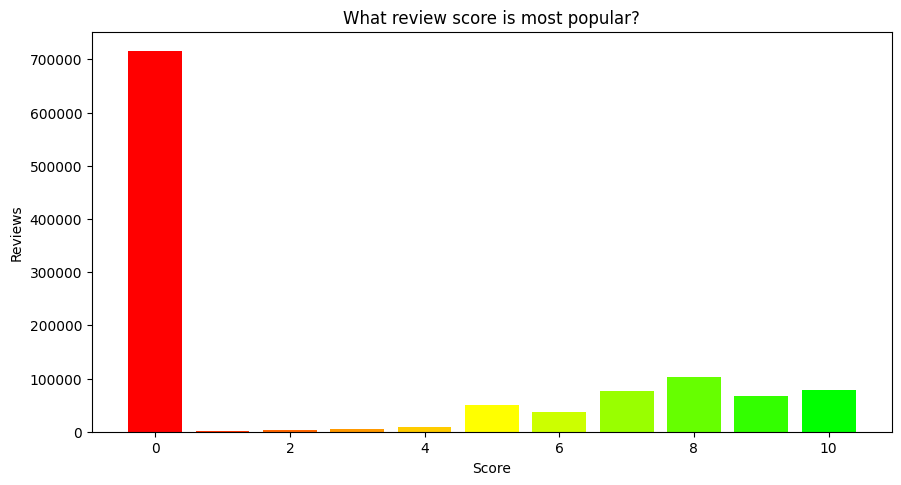


The global review average is 2.87

There are 38,881 users (36.93%) who's average review is lower than 3

Insight: Either our users hate our selection or they don't write about the books they loved.



In [104]:
### REVIEWS AND USER BEHAVIOR GRAPHS AND VISUALS

grouped_by_user = df_ratings.groupby(['user'])
user_ratings = grouped_by_user['rating'].agg(['sum', 'count', 'mean']).reset_index()

print('--- BASIC STATS\n')
user_count = len(grouped_by_user['user'])
review_count = len(df_ratings)
most_active_list = user_ratings.sort_values(by='count')
most_active_user = most_active_list.iloc[-1];
print('There is over {:,} reviews in the database written by {:,} users'.format(review_count, user_count))
print('The most active user (ID: #{}) has written {:,} reviews\n'.format(most_active_user.name, int(most_active_user['count'])))

print('\n--- WHERE DO MOST OF OUR REVIEWS COME FROM?\n')
# Graph
SLICE_NUMBERS = 5
step_size = int(user_count/SLICE_NUMBERS)
percentile = int(100 / SLICE_NUMBERS);
labels_percentile = ['{}%-{}%'.format(100-(n*percentile), 100-((n+1)*percentile)) for n in range(SLICE_NUMBERS)]
count_per_percentile = []
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
reviews_distribution = most_active_list['count'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
).sum()
most_active_list['distribution'] = reviews_distribution

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
ax.bar(labels_percentile, reviews_distribution.tolist())
plt.title('Which user group contributes the most?')
plt.xlabel('Percentile')
plt.ylabel('Reviews')
plt.show()

# Hard numbers
top_reviewers_count = most_active_list.iloc[-step_size:]['count'].sum()
print('\nThe top {}% of users contributed to {}% of reviews'.format(percentile, round(top_reviewers_count/review_count*100,2)))

print("\nInsight: Almost all our reviews come from 'superusers' who have a lot of opinions to share\n")

print('\n--- HOW MANY REVIEWS DO USERS USUALLY LEAVE?\n')
# Graph
binned = pd.cut(user_ratings['count'], bins=[0,100,200,500,1000])
ax = binned.value_counts(sort=False).plot.bar(rot=0, figsize=(8,4))
ax.set_xticklabels(["{} to {}".format(c.left, c.right) for c in binned.cat.categories])
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('How many reviews does each user have?')
plt.ylabel("Users")
plt.xlabel("# of reviews per account")
plt.show()

# Hard numbers
LOW_COUNT_THRESOLD = 10
inactive_users = user_ratings[user_ratings['count'] < LOW_COUNT_THRESOLD]
inactive_count = len(inactive_users)
inactive_percentage = round(inactive_count/user_count*100,2)
#print('\nThere are {:,} users ({}%) who have written less than {} reviews'.format(inactive_count, inactive_percentage, LOW_COUNT_THRESOLD));

#print("\nInsight: Most users will write less than 10 reviews")

print('\n--- WHAT IS THE RELATIONSHIP B/T ENGAGEMENT RATE AND AVERAGE REVIEW SCORES?\n')
# Graph
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
score_distribution = most_active_list['mean'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
).mean()
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(labels_percentile, reviews_distribution.tolist())
ax2 = ax.twinx()
ax2.plot(labels_percentile, score_distribution.tolist(), color = 'red')
ax.set_xlabel('Percentile')
ax.set_ylabel('Review count')
ax2.set_ylabel('Avg rating')
ax2.set_ylim(0,10)

plt.title('Review sentiment across active percentile?')
plt.xlabel('Review count')
plt.show()

# Hard number
score_range = (0, 6)
reviews_within_range = df_ratings.query('{} <= rating <= {}'.format(score_range[0], score_range[1]))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg = df_ratings['rating'].mean()
print('\nThe average review is {0:.2f}'.format(avg))
#print('\nThere is {:,} ({}%) reviews that are between {} and {}'.format(within_range_count, within_range_percent, score_range[0], score_range[1]))

#print('\nInsight: There is no correlation with sustained engagement and rating\n')

print('\n--- WHAT REVIEW SCORES ARE MOST OFTEN POSTED ON THE SITE?\n')

# Graph
grouped_by_score = df_ratings.groupby(['rating']).count()
scores = df_ratings['rating'].unique().tolist()
scores.sort()
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
colors = ['#FF0000','#FF3300', '#ff6600', '#ff9900', '#FFCC00','#FFFF00', '#ccff00', '#99ff00', '#66ff00', '#33ff00', '#00FF00']
ax.bar(scores, grouped_by_score['user'], color=colors)
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('What review score is most popular?')
plt.xlabel('Score')
plt.ylabel('Reviews')
plt.show()

# Hard number
low_score_threshold = 2
reviews_within_range = df_ratings.query('rating < {}'.format(low_score_threshold))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg = df_ratings['rating'].mean()
print('\nThe global review average is {0:.2f}'.format(avg))
#print('\nThere is {:,} ({}%) reviews lower than {}'.format(within_range_count, within_range_percent, low_score_threshold))

# How many users are chronical haters ?
HATER_THRESHOLD = 3
haters = user_ratings[user_ratings['mean'] < HATER_THRESHOLD]
haters_count = len(haters)
hater_percentage = round(haters_count/user_count*100,2)
print('\nThere are {:,} users ({}%) who\'s average review is lower than {}'.format(haters_count, hater_percentage, HATER_THRESHOLD));

print('\nInsight: Either our users hate our selection or they don\'t write about the books they loved.\n')

--- BASIC STATS

There is over 1,149,780 reviews in the database written by 105,283 users
The most active user (ID: #4213) has written 13,602 reviews


--- WHERE DO MOST OF OUR REVIEWS COME FROM?



/tmp/ipython-input-107-3019351171.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  reviews_distribution = most_active_list['count'].groupby(


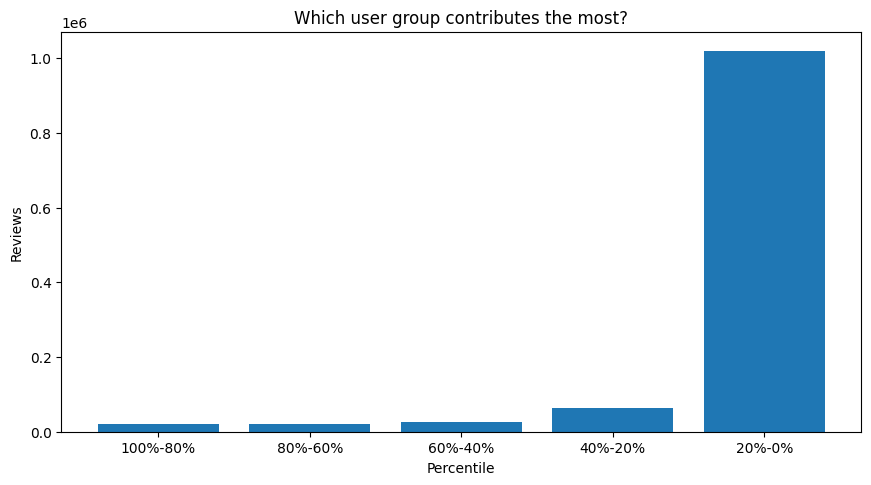


The top 20% of users contributed to 88.73% of reviews

Insight: Almost all our reviews come from 'superusers' who have a lot of opinions to share


--- HOW MANY REVIEWS DO USERS USUALLY LEAVE?



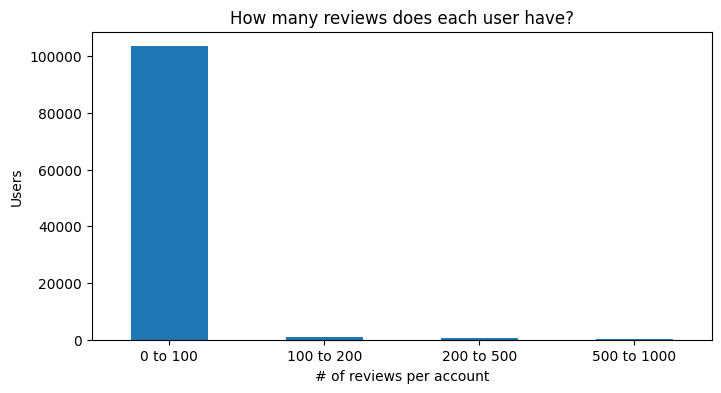


--- WHAT IS THE RELATIONSHIP B/T ENGAGEMENT RATE AND AVERAGE REVIEW SCORES?



/tmp/ipython-input-107-3019351171.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_distribution = most_active_list['mean'].groupby(


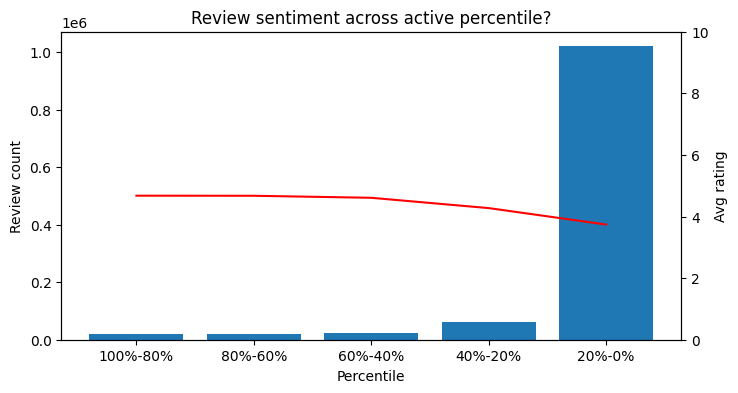


The average review is 2.87

--- WHAT REVIEW SCORES ARE MOST OFTEN POSTED ON THE SITE?



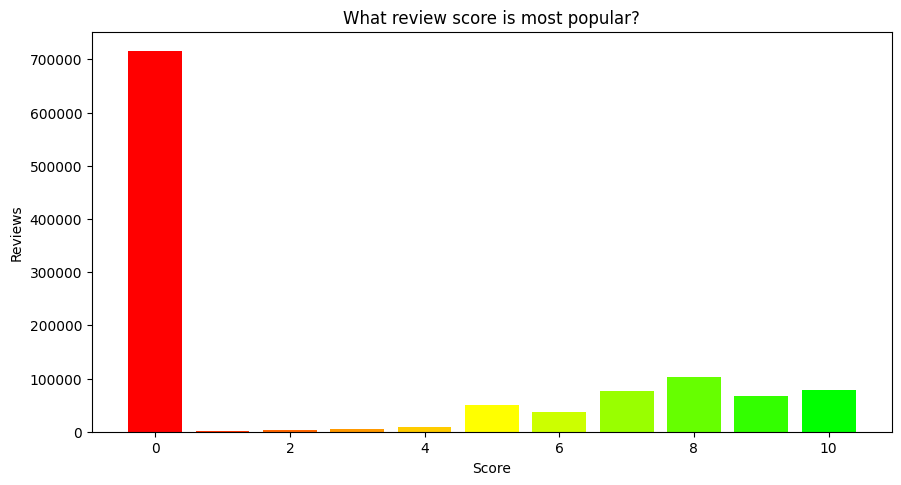


The global review average is 2.87

There are 38,881 users (36.93%) who's average review is lower than 3

Insight: Either our users hate our selection or they don't write about the books they loved.



In [107]:
### REVIEWS AND USER BEHAVIOR GRAPHS AND VISUALS

grouped_by_user = df_ratings.groupby(['user'])
user_ratings = grouped_by_user['rating'].agg(['sum', 'count', 'mean']).reset_index()

print('--- BASIC STATS\n')
user_count = len(grouped_by_user['user'])
review_count = len(df_ratings)
most_active_list = user_ratings.sort_values(by='count')
most_active_user = most_active_list.iloc[-1];
print('There is over {:,} reviews in the database written by {:,} users'.format(review_count, user_count))
print('The most active user (ID: #{}) has written {:,} reviews\n'.format(most_active_user.name, int(most_active_user['count'])))

print('\n--- WHERE DO MOST OF OUR REVIEWS COME FROM?\n')
# Graph
SLICE_NUMBERS = 5
step_size = int(user_count/SLICE_NUMBERS)
percentile = int(100 / SLICE_NUMBERS);
labels_percentile = ['{}%-{}%'.format(100-(n*percentile), 100-((n+1)*percentile)) for n in range(SLICE_NUMBERS)]
count_per_percentile = []
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
reviews_distribution = most_active_list['count'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
).sum()
most_active_list['distribution'] = reviews_distribution

fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
ax.bar(labels_percentile, reviews_distribution.tolist())
plt.title('Which user group contributes the most?')
plt.xlabel('Percentile')
plt.ylabel('Reviews')
plt.show()

# Hard numbers
top_reviewers_count = most_active_list.iloc[-step_size:]['count'].sum()
print('\nThe top {}% of users contributed to {}% of reviews'.format(percentile, round(top_reviewers_count/review_count*100,2)))

print("\nInsight: Almost all our reviews come from 'superusers' who have a lot of opinions to share\n")

print('\n--- HOW MANY REVIEWS DO USERS USUALLY LEAVE?\n')
# Graph
binned = pd.cut(user_ratings['count'], bins=[0,100,200,500,1000])
ax = binned.value_counts(sort=False).plot.bar(rot=0, figsize=(8,4))
ax.set_xticklabels(["{} to {}".format(c.left, c.right) for c in binned.cat.categories])
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('How many reviews does each user have?')
plt.ylabel("Users")
plt.xlabel("# of reviews per account")
plt.show()

# Hard numbers
LOW_COUNT_THRESOLD = 10
inactive_users = user_ratings[user_ratings['count'] < LOW_COUNT_THRESOLD]
inactive_count = len(inactive_users)
inactive_percentage = round(inactive_count/user_count*100,2)
#print('\nThere are {:,} users ({}%) who have written less than {} reviews'.format(inactive_count, inactive_percentage, LOW_COUNT_THRESOLD));

#print("\nInsight: Most users will write less than 10 reviews")

print('\n--- WHAT IS THE RELATIONSHIP B/T ENGAGEMENT RATE AND AVERAGE REVIEW SCORES?\n')
# Graph
quartile = [round(((n+1)*percentile/100)-0.2, 1) for n in range(SLICE_NUMBERS+1)]
score_distribution = most_active_list['mean'].groupby(
    pd.qcut(most_active_list['count'].rank(method='first'), q=quartile)
).mean()
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(labels_percentile, reviews_distribution.tolist())
ax2 = ax.twinx()
ax2.plot(labels_percentile, score_distribution.tolist(), color = 'red')
ax.set_xlabel('Percentile')
ax.set_ylabel('Review count')
ax2.set_ylabel('Avg rating')
ax2.set_ylim(0,10)

plt.title('Review sentiment across active percentile?')
plt.xlabel('Review count')
plt.show()

# Hard number
score_range = (0, 6)
reviews_within_range = df_ratings.query('{} <= rating <= {}'.format(score_range[0], score_range[1]))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg = df_ratings['rating'].mean()
print('\nThe average review is {0:.2f}'.format(avg))
#print('\nThere is {:,} ({}%) reviews that are between {} and {}'.format(within_range_count, within_range_percent, score_range[0], score_range[1]))

#print('\nInsight: There is no correlation with sustained engagement and rating\n')

print('\n--- WHAT REVIEW SCORES ARE MOST OFTEN POSTED ON THE SITE?\n')

# Graph
grouped_by_score = df_ratings.groupby(['rating']).count()
scores = df_ratings['rating'].unique().tolist()
scores.sort()
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,0,1,1])
colors = ['#FF0000','#FF3300', '#ff6600', '#ff9900', '#FFCC00','#FFFF00', '#ccff00', '#99ff00', '#66ff00', '#33ff00', '#00FF00']
ax.bar(scores, grouped_by_score['user'], color=colors)
#ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title('What review score is most popular?')
plt.xlabel('Score')
plt.ylabel('Reviews')
plt.show()

# Hard number
low_score_threshold = 2
reviews_within_range = df_ratings.query('rating < {}'.format(low_score_threshold))
within_range_count = len(reviews_within_range)
within_range_percent = round(within_range_count/review_count * 100, 2)
avg = df_ratings['rating'].mean()
print('\nThe global review average is {0:.2f}'.format(avg))
#print('\nThere is {:,} ({}%) reviews lower than {}'.format(within_range_count, within_range_percent, low_score_threshold))

# How many users are chronical haters ?
HATER_THRESHOLD = 3
haters = user_ratings[user_ratings['mean'] < HATER_THRESHOLD]
haters_count = len(haters)
hater_percentage = round(haters_count/user_count*100,2)
print('\nThere are {:,} users ({}%) who\'s average review is lower than {}'.format(haters_count, hater_percentage, HATER_THRESHOLD));

print('\nInsight: Either our users hate our selection or they don\'t write about the books they loved.\n')

In [108]:
# FORMAT THE LAST DATA BEFORE CREATING MODAL
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

df = df_ratings
counts1 = df['user'].value_counts()
counts2 = df['isbn'].value_counts()

df = df[~df['user'].isin(counts1[counts1 < 200].index)]
df = df[~df['isbn'].isin(counts2[counts2 < 100].index)]


merged_df = pd.merge(right=df, left = df_books, on="isbn")
merged_df = merged_df.drop_duplicates(subset=["title", "user"])

books_features_pivot = merged_df.pivot(
  index='title',
  columns='user',
  values='rating'
).fillna(0)

mat_books_features = csr_matrix(books_features_pivot.values)

In [109]:
## function to return recommended books - this will be tested
def get_recommends(book = "", n = 5):
  """
  make top n books recommendations
  Parameters
  ----------
  book: str, name of user input book
  n: int, top n recommendations
  """
  # Prepare for model
  pivot = books_features_pivot
  titles = list(pivot.index.values)
  data = pivot.values

  def title_2_index(title):
    ind = titles.index(title)
    return data[ind,:]

  def index_2_title(ind):
    return titles[ind]


  # Build model
  model = NearestNeighbors(metric="cosine",algorithm="brute", p=2)
  model.fit(data)

  # Run model to get recommendations
  idx = title_2_index(book)
  distances, indices = model.kneighbors(
    np.reshape(idx,[1,-1]),
    n_neighbors=n+1
  )

  raw_recommends = sorted(
    list(
      zip(
        indices.squeeze().tolist(),
        distances.squeeze().tolist()
      )
    ),
    key=lambda x: x[1]
  )[1:]

  # print results
  recommended_books = []
  print('Recommendations for {}:'.format(book))
  for i, (idx, dist) in enumerate(raw_recommends):
      dist = dist
      recommended_books.append([index_2_title(idx), dist])
      print('{0}: {1}, with distance of {2:,.2f}'.format(i+1, index_2_title(idx), dist))
  print('-----------------')
  return [book, recommended_books]

In [110]:
def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))", 10)
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True', 'The Lovely Bones: A Novel']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77, 0.72]
  recommended_books.reverse()
  recommended_books_dist.reverse()

  for i in range(2):
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

Recommendations for Where the Heart Is (Oprah's Book Club (Paperback)):
1: The Lovely Bones: A Novel, with distance of 0.72
2: I Know This Much Is True, with distance of 0.77
3: The Surgeon, with distance of 0.77
4: The Weight of Water, with distance of 0.77
5: I'll Be Seeing You, with distance of 0.80
6: The Dive From Clausen's Pier (Alex Awards), with distance of 0.80
7: Tis: A Memoir, with distance of 0.81
8: Icy Sparks, with distance of 0.81
9: Unspeakable, with distance of 0.81
10: What Looks Like Crazy On An Ordinary Day, with distance of 0.82
-----------------
You passed the challenge! 🎉🎉🎉🎉🎉
